## Import packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import PartialDependenceDisplay
backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Read the dataset

In [2]:
medical_costs=pd.read_csv('https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Medical%20Cost%20Insurance/medical_cost_insurance.csv')

## Exploring the data

In [3]:
medical_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
medical_costs.children=medical_costs.children.astype('object')
medical_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   object 
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 73.3+ KB


## Univariate EDA

### Categorical columns

In [5]:
cat_col_df=medical_costs.select_dtypes('object')
for col in cat_col_df.columns.values:
    print(cat_col_df[col].value_counts(normalize=True),'\n')

sex
male      0.505232
female    0.494768
Name: proportion, dtype: float64 

children
0    0.428999
1    0.242152
2    0.179372
3    0.117339
4    0.018685
5    0.013453
Name: proportion, dtype: float64 

smoker
no     0.795217
yes    0.204783
Name: proportion, dtype: float64 

region
southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: proportion, dtype: float64 



In [6]:
medical_costs.children=np.where((medical_costs['children']==3) | (medical_costs['children']==4) | (medical_costs['children']==5), '3 or more', medical_costs.children)
medical_costs.children.value_counts(normalize=True)

children
0            0.428999
1            0.242152
2            0.179372
3 or more    0.149477
Name: proportion, dtype: float64

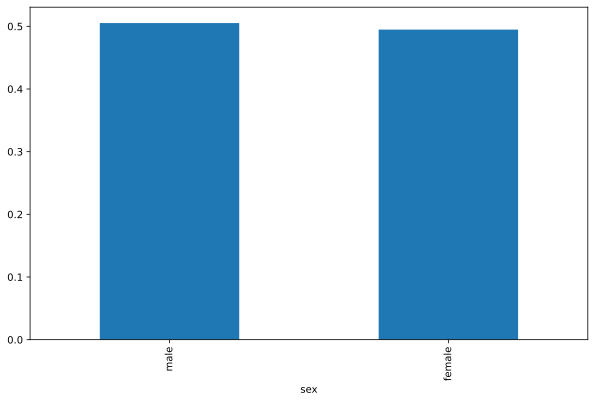

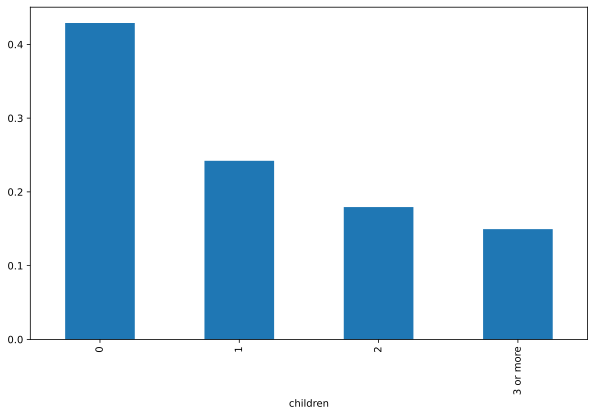

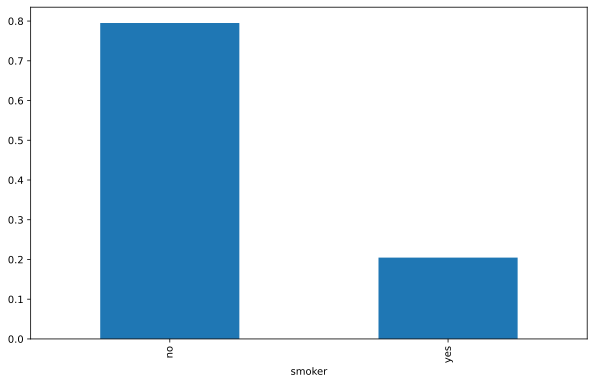

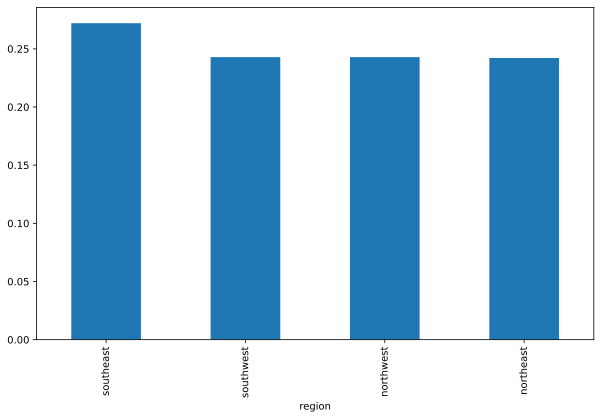

In [7]:
cat_col_df=medical_costs.select_dtypes('object')
for col in cat_col_df.columns.values:
    plt.figure(figsize=(10,6))
    cat_col_df[col].value_counts(normalize=True).plot.bar(stacked=True)
    plt.show()

### Numerical columns

In [8]:
num_col_df=medical_costs.select_dtypes('number')
num_col_df.describe()

,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


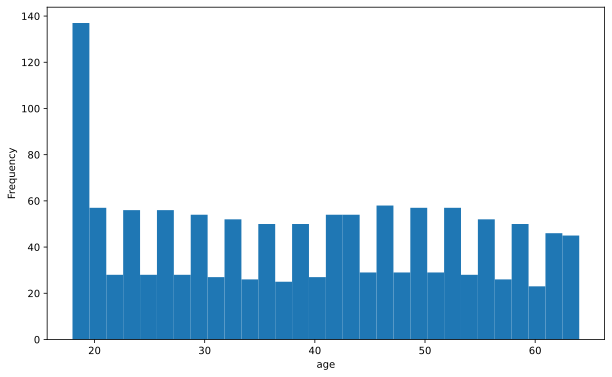

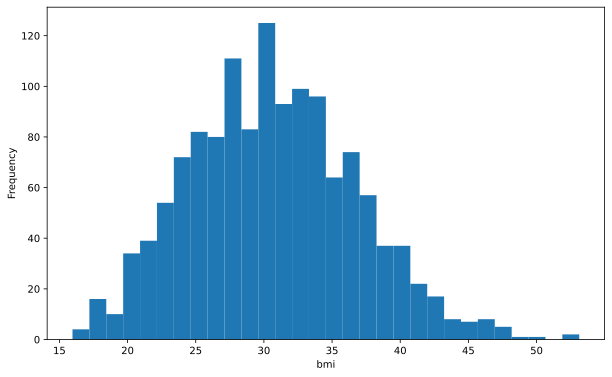

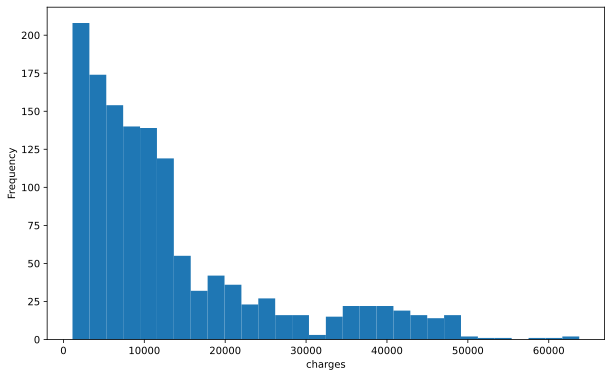

In [9]:
for col in num_col_df.columns.values:
    plt.figure(figsize=(10,6))
    num_col_df[col].plot.hist(bins=30)
    plt.xlabel(col)
    plt.show()

## Within features bivariate EDA

In [10]:
num_col_features_df=num_col_df.drop(columns=['charges'])
num_col_features_df.corr()

,age,bmi
age,1.000000,0.109272
bmi,0.109272,1.000000


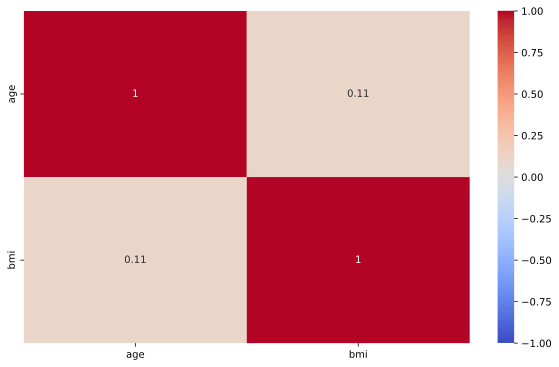

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(num_col_features_df.corr(numeric_only=True),
            annot=True,
            cmap='coolwarm',
            vmax=1,
            vmin=-1
);

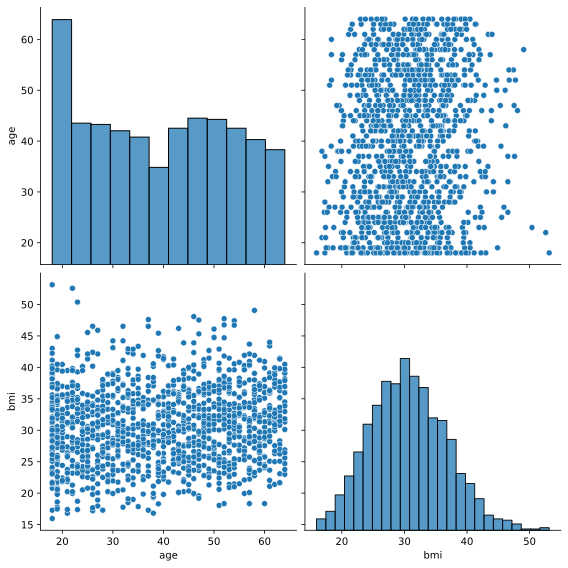

In [12]:
sns.pairplot(num_col_features_df,size=4)
plt.show()

In [13]:
for col1 in cat_col_df.columns.values:
    for col2 in cat_col_df.columns.values:
        if col1 != col2:
            print(pd.crosstab(cat_col_df[col1],cat_col_df[col2],normalize='index',margins=True),'\n')

children         0         1         2  3 or more
sex                                              
female    0.436556  0.238671  0.179758   0.145015
male      0.421598  0.245562  0.178994   0.153846
All       0.428999  0.242152  0.179372   0.149477 

smoker        no       yes
sex                       
female  0.826284  0.173716
male    0.764793  0.235207
All     0.795217  0.204783 

region  northeast  northwest  southeast  southwest
sex                                               
female   0.243202   0.247734   0.264350   0.244713
male     0.241124   0.238166   0.279586   0.241124
All      0.242152   0.242900   0.272048   0.242900 

sex          female      male
children                     
0          0.503484  0.496516
1          0.487654  0.512346
2          0.495833  0.504167
3 or more  0.480000  0.520000
All        0.494768  0.505232 

smoker           no       yes
children                     
0          0.799652  0.200348
1          0.811728  0.188272
2          0.770833  0

<Figure size 1000x600 with 0 Axes>

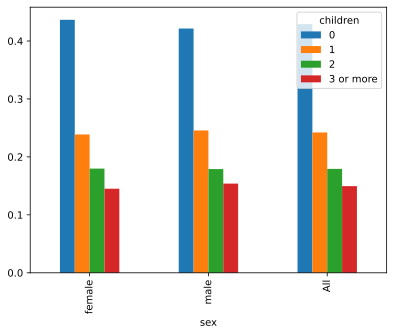

<Figure size 1000x600 with 0 Axes>

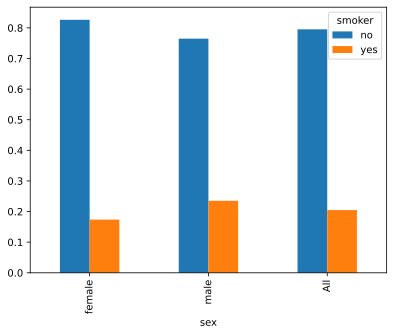

<Figure size 1000x600 with 0 Axes>

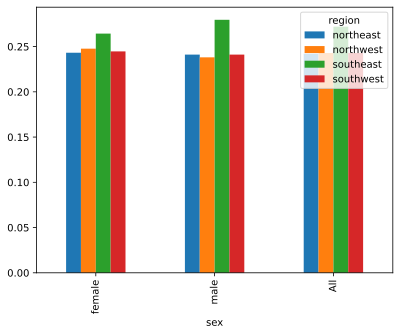

<Figure size 1000x600 with 0 Axes>

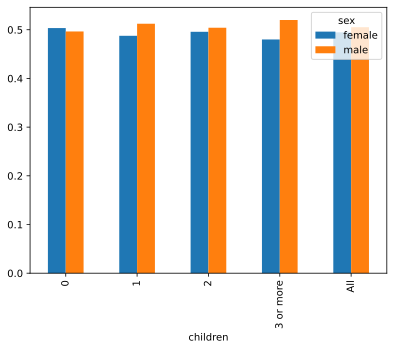

<Figure size 1000x600 with 0 Axes>

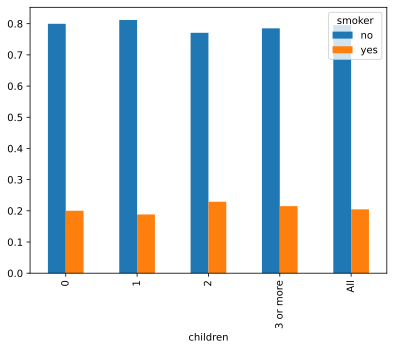

<Figure size 1000x600 with 0 Axes>

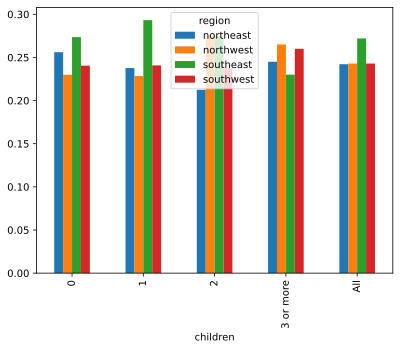

<Figure size 1000x600 with 0 Axes>

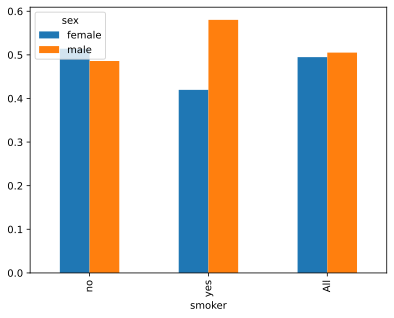

<Figure size 1000x600 with 0 Axes>

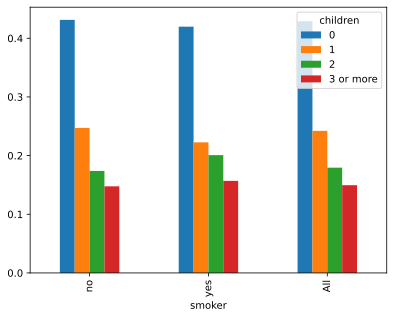

<Figure size 1000x600 with 0 Axes>

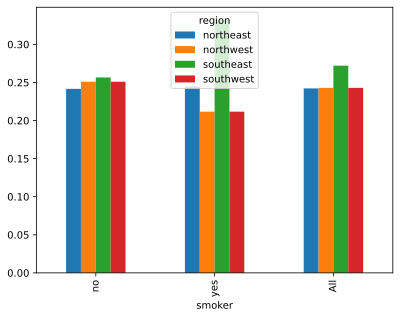

<Figure size 1000x600 with 0 Axes>

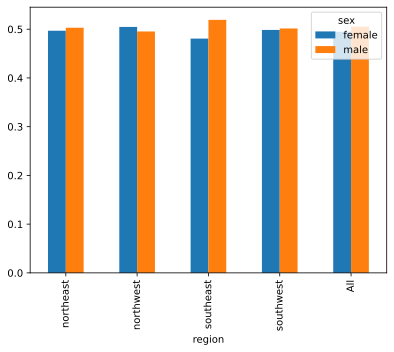

<Figure size 1000x600 with 0 Axes>

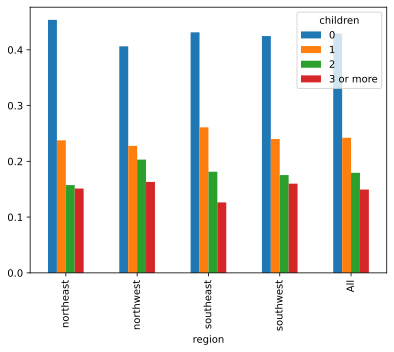

<Figure size 1000x600 with 0 Axes>

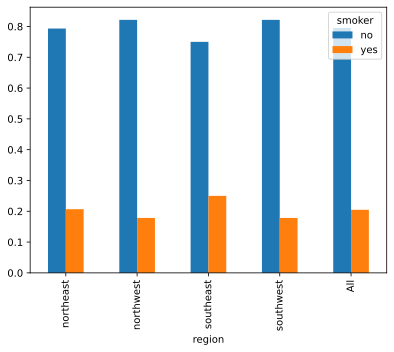

In [14]:
for col1 in cat_col_df.columns.values:
    for col2 in cat_col_df.columns.values:
        if col1 != col2:
            plt.figure(figsize=(10,6))
            pd.crosstab(cat_col_df[col1],cat_col_df[col2],normalize='index',margins=True).plot.bar()
            plt.show()

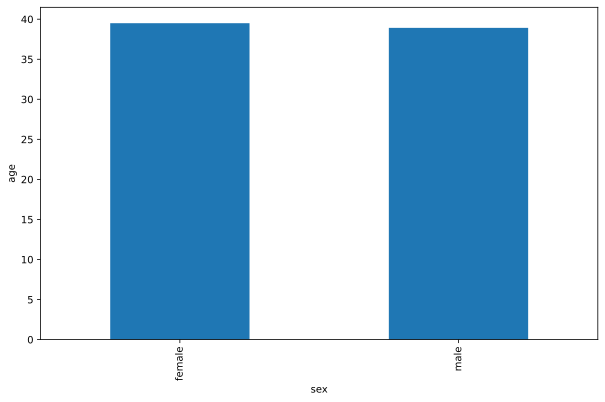

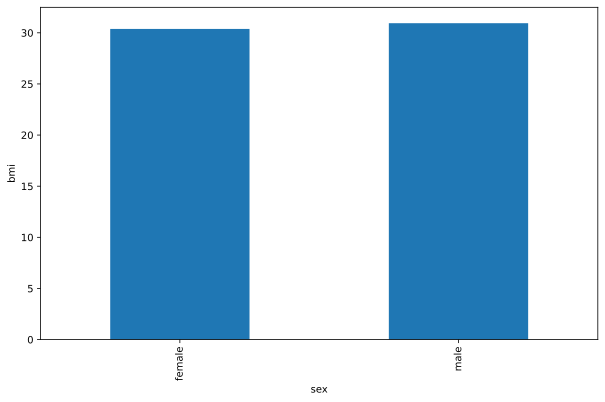

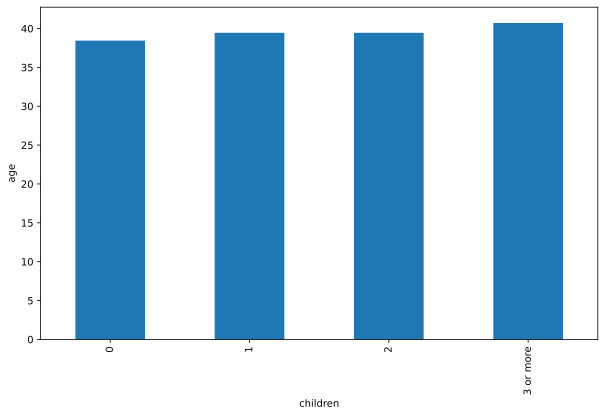

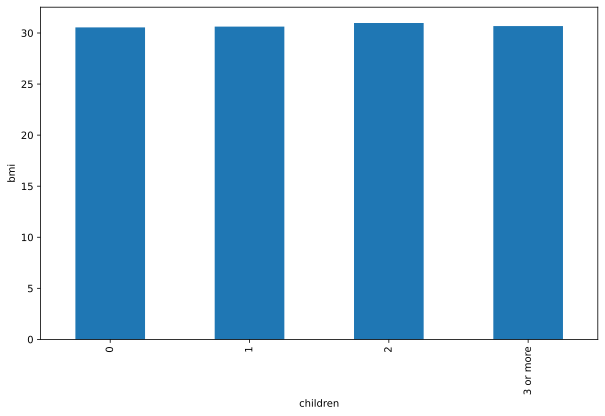

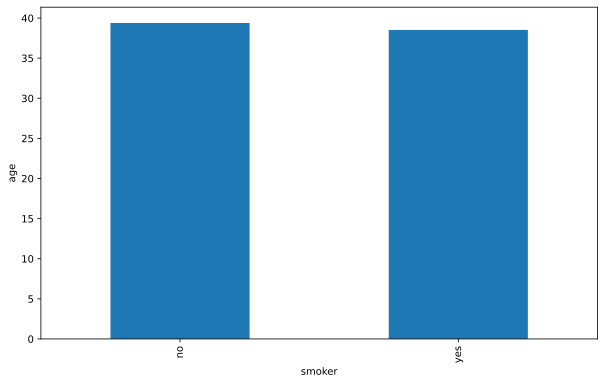

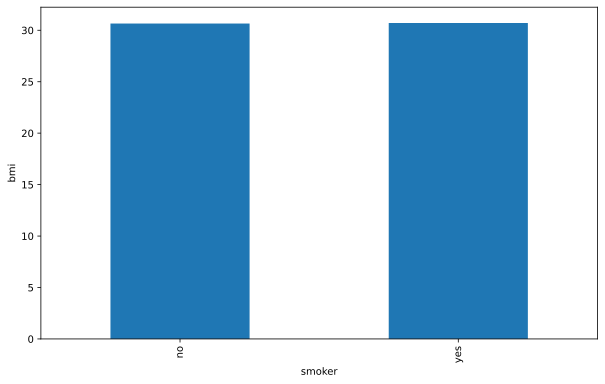

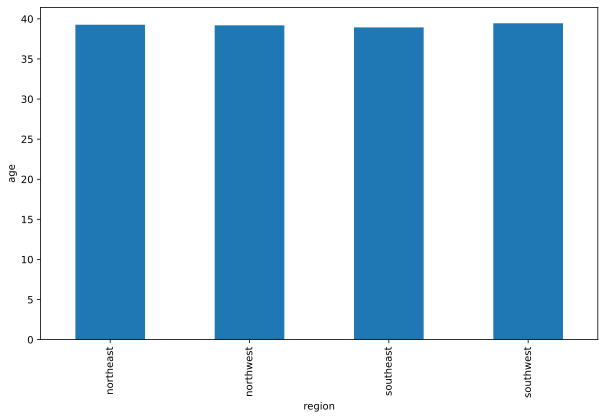

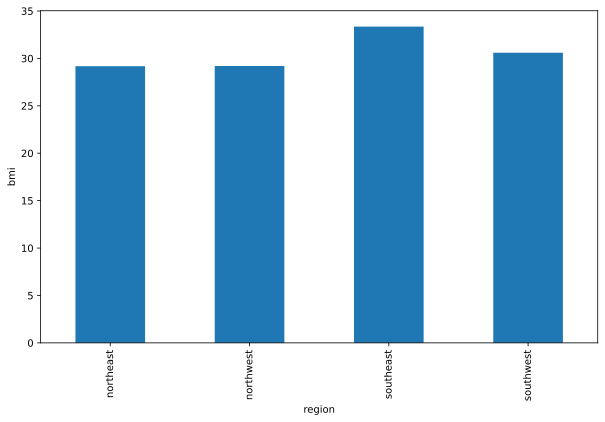

In [15]:
for cat_col in cat_col_df.columns.values:
    for num_col in num_col_df.columns.values:
        if num_col!='charges':
            plt.figure(figsize=(10,6))
            medical_costs.groupby(cat_col)[num_col].mean().plot.bar()
            plt.ylabel(num_col)
            plt.show()

## Between feature and target bivariate EDA

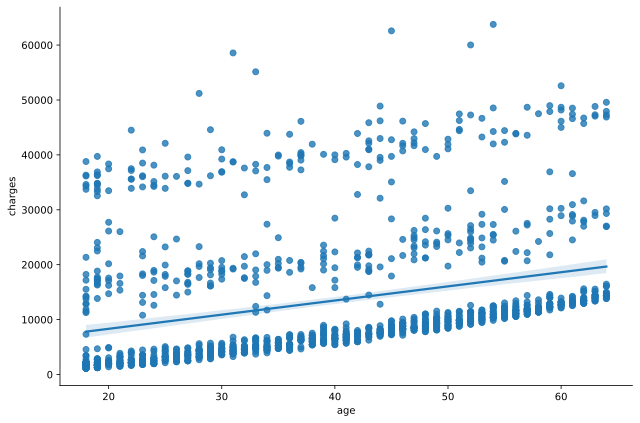

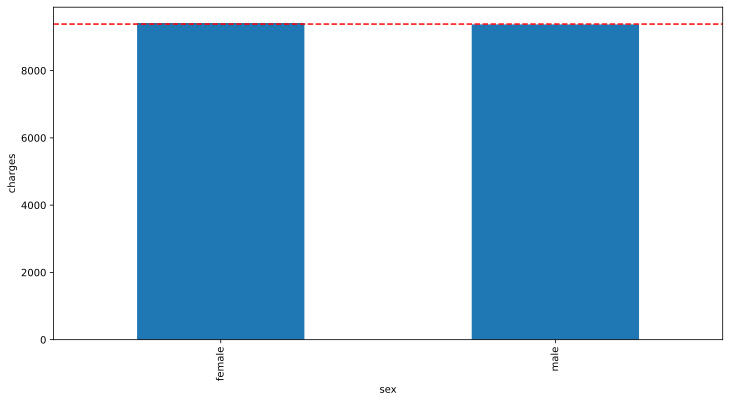

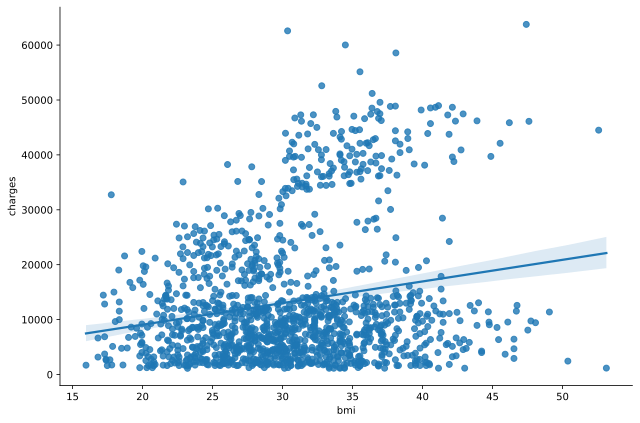

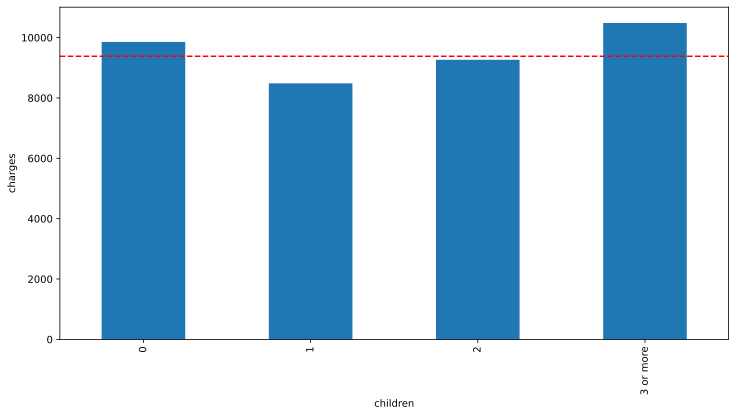

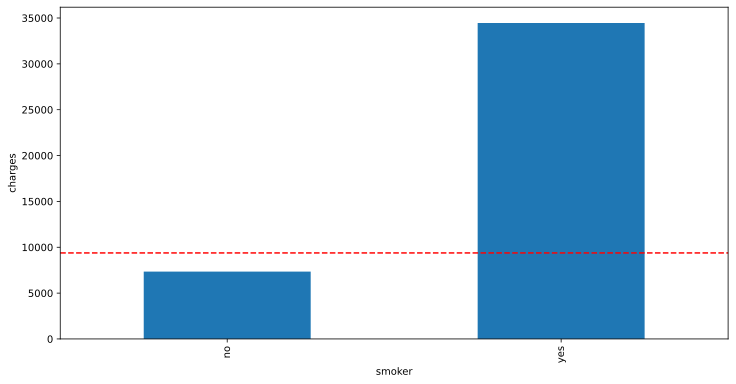

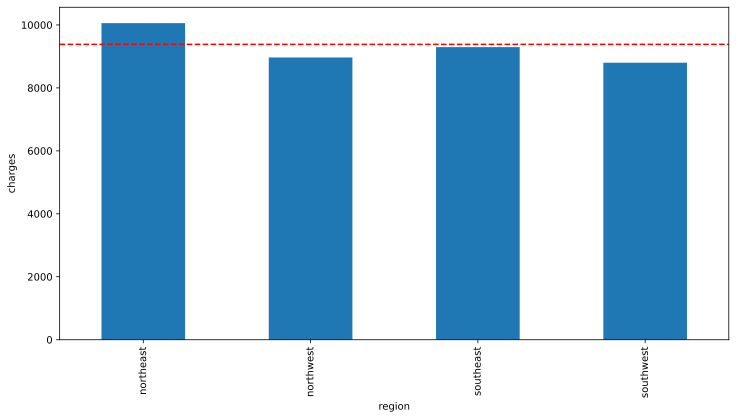

In [16]:
for col in medical_costs.drop(columns=['charges'],axis=1).columns.values:
    if medical_costs[col].dtypes=='object':
        plt.subplots(figsize=(12,6))
        medical_costs.groupby(col)['charges'].median().plot.bar()
        plt.axhline(y=medical_costs.charges.median(), color='red', linestyle='--')
        plt.ylabel('charges')
        plt.show()
    else:
        sns.lmplot(data=medical_costs,x=col,y='charges',fit_reg=True,height=6,aspect=1.5)
        plt.show()

## Feature engineering for model building

In [17]:
children=pd.get_dummies(medical_costs.children,prefix='children',drop_first=True).astype('int64')
region=pd.get_dummies(medical_costs.region,prefix='region',drop_first=True).astype('int64')
sex=pd.get_dummies(medical_costs.sex,prefix='sex',drop_first=True).astype('int64')
smoker=pd.get_dummies(medical_costs.smoker,prefix='smoker',drop_first=True).astype('int64')
cat_dummy_df=pd.concat([sex,smoker,region,children],join='inner',axis=1)

In [18]:
num_features=medical_costs.select_dtypes('number').drop(columns=['charges'],axis=1)

In [19]:
X=pd.concat([num_features,cat_dummy_df],axis=1,join='inner')
y=medical_costs.charges

## Preprocessing

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [21]:
scaler=MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [22]:
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

## Model building

### Finding the best random state

In [23]:
mae_diff={}
for rs in range(1,1000):
    rf=GradientBoostingRegressor(random_state=rs)
    cv=KFold(n_splits=10,shuffle=True,random_state=rs)
    cv_mae=cross_val_score(
        estimator=rf,
        X=X_train_scaled,
        y=y_train,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    ).mean()*-1
    # print(f'cv MAE: {cv_mae}')
    rf.fit(X_train_scaled,y_train)
    pred=rf.predict(X_test_scaled)
    test_mae=mean_absolute_error(y_true=y_test,y_pred=pred)
    # print(f'Test MAE: {test_mae}')
    mae_diff[rs]=abs(test_mae-cv_mae)
best_random_state=min(mae_diff,key=mae_diff.get)
print(f'Best random state = {best_random_state}')
print(f'Lowest MAE = {mae_diff[best_random_state]}')

Best random state = 779
Lowest MAE = 88.11579066884133


## Selecting the best ML algorithm

In [24]:
def get_model_scores(model):
    cv=KFold(n_splits=10,shuffle=True,random_state=best_random_state)
    cv_mae=cross_val_score(
        estimator=model,
        X=X_train_scaled,
        y=y_train,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    ).mean()*-1
    model.fit(X_train_scaled,y_train)
    print(f'CV MAE = {cv_mae}')
    print(f'Test MAE = {mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test_scaled))}')
    print(f'MAE difference between cv and test = {abs(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test_scaled))-cv_mae)}')
    return abs(mean_absolute_error(y_true=y_test,y_pred=model.predict(X_test_scaled))-cv_mae)

In [25]:
ml_algo_dict={}

In [26]:
# Linear regression
lr=LinearRegression()
ml_algo_dict[lr]=get_model_scores(lr)

CV MAE = 4259.401947535446
Test MAE = 4212.537915136437
MAE difference between cv and test = 46.864032399009375


In [27]:
# Elastic net
en=ElasticNet(random_state=best_random_state)
ml_algo_dict[en]=get_model_scores(en)

CV MAE = 7413.474507819618
Test MAE = 7822.295921535139
MAE difference between cv and test = 408.821413715521


In [28]:
# Ridge
ridge=Ridge(random_state=best_random_state)
ml_algo_dict[ridge]=get_model_scores(ridge)

CV MAE = 4253.341872742558
Test MAE = 4207.58694853694
MAE difference between cv and test = 45.7549242056175


In [29]:
# Lasso
lasso=Lasso(random_state=best_random_state)
ml_algo_dict[lasso]=get_model_scores(lasso)

CV MAE = 4258.181828016715
Test MAE = 4211.866867521106
MAE difference between cv and test = 46.31496049560974


In [30]:
# Decission tree
dt=DecisionTreeRegressor(random_state=best_random_state)
ml_algo_dict[dt]=get_model_scores(dt)

CV MAE = 3224.7912173504674
Test MAE = 3327.4593053955227
MAE difference between cv and test = 102.66808804505536


In [31]:
# Random forest
rf=RandomForestRegressor(random_state=best_random_state)
ml_algo_dict[rf]=get_model_scores(rf)

CV MAE = 2829.5355413526586
Test MAE = 2590.4810022301317
MAE difference between cv and test = 239.05453912252688


In [32]:
# Support vector regression
svr=SVR()
ml_algo_dict[svr]=get_model_scores(svr)

CV MAE = 8279.467353614247
Test MAE = 8622.650083998558
MAE difference between cv and test = 343.18273038431107


In [33]:
# Bagging regressor
bgr=BaggingRegressor(random_state=best_random_state)
ml_algo_dict[bgr]=get_model_scores(bgr)

CV MAE = 2933.2271973958723
Test MAE = 2610.6979706361944
MAE difference between cv and test = 322.52922675967784


In [34]:
# Gradient boosting
gbr=GradientBoostingRegressor(random_state=best_random_state)
ml_algo_dict[gbr]=get_model_scores(gbr)

CV MAE = 2551.298656292308
Test MAE = 2463.1828656234666
MAE difference between cv and test = 88.11579066884133


In [35]:
selected_model=min(ml_algo_dict,key=ml_algo_dict.get)
y_pred=selected_model.predict(X_test_scaled)
mean_absolute_error(y_true=y_test,y_pred=y_pred)

4207.58694853694

## Hyperparameter tuning

In [36]:
param_grid={
    'alpha': np.linspace(0,1000,10001),
    'fit_intercept': [True,False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
}
cv=KFold(n_splits=10,shuffle=True,random_state=best_random_state)
model=GridSearchCV(
    estimator=selected_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
model.fit(X_train_scaled,y_train)
model.best_score_

-4248.2853437341055

### the earlier model performed better than the best model found through hyperparameter tuning. So the earlier selected model is our final model

### Feature importance

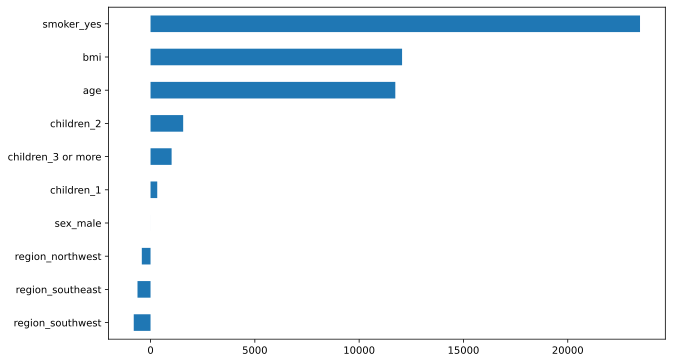

In [37]:
feature_importance=pd.Series(data=selected_model.coef_,index=X.columns.values)
plt.figure(figsize=(10,6))
feature_importance.sort_values().plot.barh();

In [38]:
feature_importance

age                   11733.269540
bmi                   12057.743851
sex_male                  0.526559
smoker_yes            23463.867949
region_northwest       -418.148471
region_southeast       -625.057682
region_southwest       -804.768186
children_1              321.156333
children_2             1564.491566
children_3 or more     1010.079058
dtype: float64

### Partial dependence plots

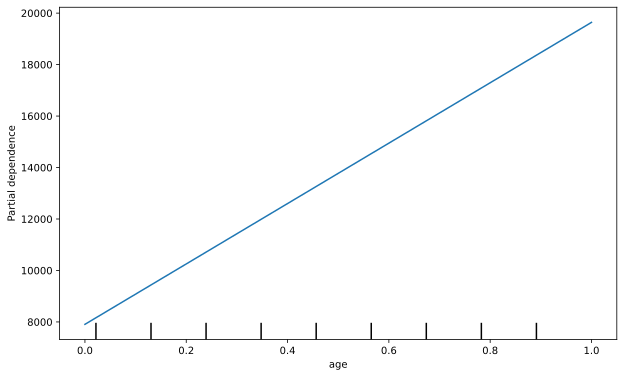

<Figure size 1000x600 with 0 Axes>

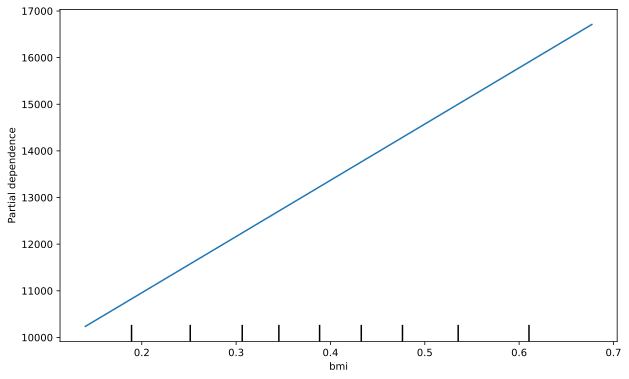

<Figure size 1000x600 with 0 Axes>

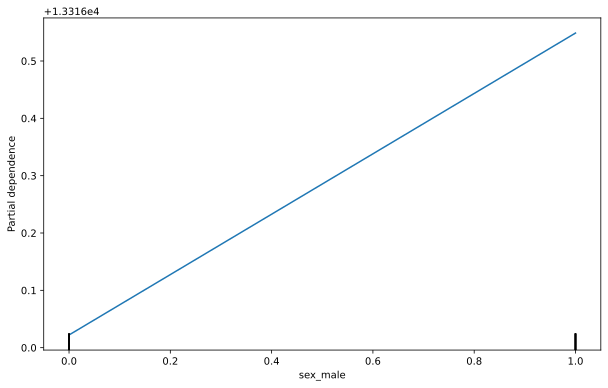

<Figure size 1000x600 with 0 Axes>

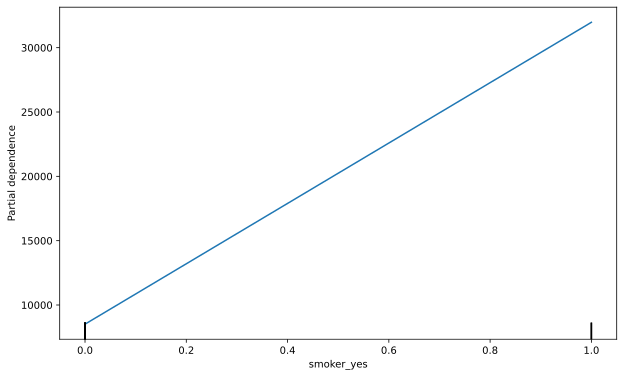

<Figure size 1000x600 with 0 Axes>

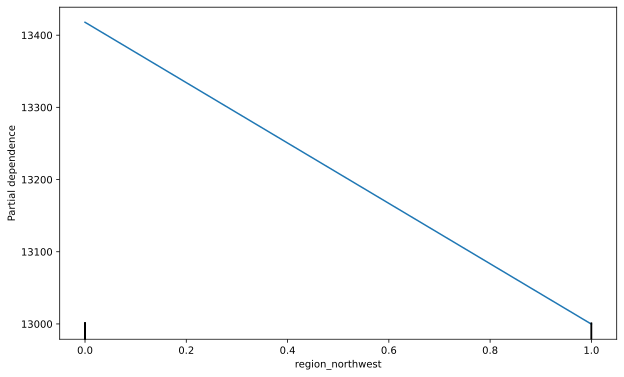

<Figure size 1000x600 with 0 Axes>

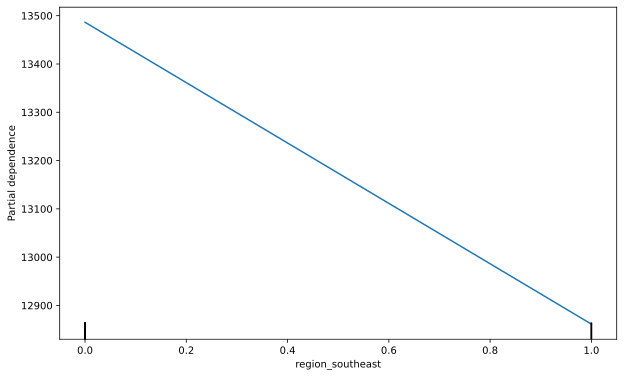

<Figure size 1000x600 with 0 Axes>

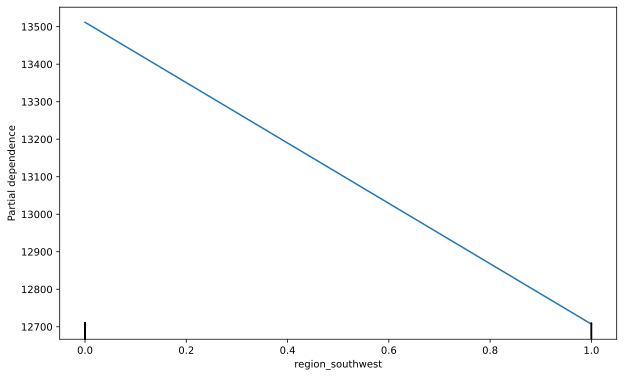

<Figure size 1000x600 with 0 Axes>

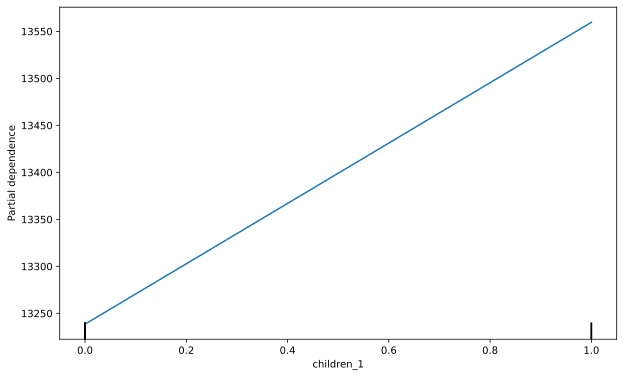

<Figure size 1000x600 with 0 Axes>

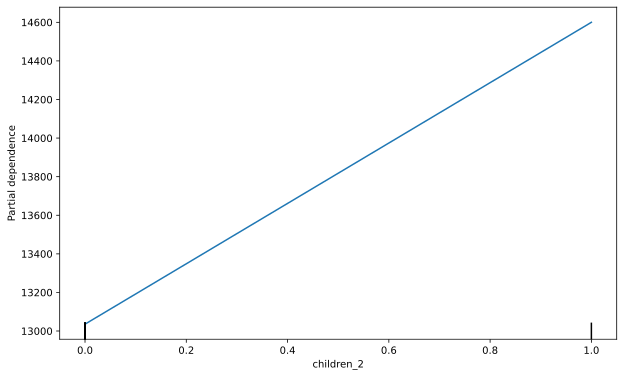

<Figure size 1000x600 with 0 Axes>

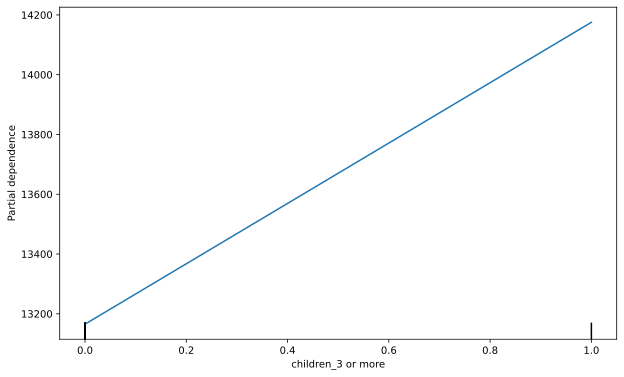

<Figure size 1000x600 with 0 Axes>

In [39]:
pred_df=pd.DataFrame(columns=X.columns.values,
                     data=scaler.transform(X))
for col in pred_df.columns.values:
    fig,ax=plt.subplots(figsize=(10, 6))
    plt.figure(figsize=(10,6))
    pdp = PartialDependenceDisplay.from_estimator(selected_model,
                                                  pred_df,
                                                  [col],
                                                  kind='average',
                                                  ax=ax
                                                  );

## Insights

#### From the feature importance plot above it is evident that smoking, bmi and age are the top three factors with smoking being the most important in determining the medical insurance claim cost to the company.

Based on the results of the above analyses, we make the below observations.

* Those who smoke are very highly likely to make a high claim for medical related cost as compared to those who don't smoke in general. As an estimate those who smoke are likely to claim $23464 more than those who don't smoke on average.
* Similarly, people with higher bmi are more likely to make higher claim. To be precise someone who is one unit higher in bmi is likely to claim $12058 more than someone who is one unit below in bmi than him/her.
* Likewise, older people are more likely to make higher claim than younger people which is normal as older people are more susceptible to fall sick thus incurring higher medical cost. Precisely, with each year in age people are likely to claim $11733 more compared to someone who is a year younger on average.
* Furthermore, people with children are likely to make higher claim compared to people with no children.
* Finally, people from northeast region are likely to make slightly higher claim compared to people from other region in general. However, this factor may not be significantly important to consider for making any business decision.

Hence, one recommendation that could be made out of these findings is that the insurance company may want to charge higher health insurance premium to those who are smoker, older, has bmi on the higher side, has children and live in the northeast region as people with this profile incur risk of high insurance loss as compared to others.